In [ ]:
import pandas as pd
import mysql.connector
import os
from mysql.connector import Error

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments'),
    ('geolocation.csv','geolocation')
]

# Folder containing the CSV files
folder_path = 'C:/Users/punitpal/OneDrive/Desktop/project_ws'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

try:
    # Connect to the MySQL database
    conn = mysql.connector.connect(
        host='localhost',
        user='root',
        password='MYfriNK@2024',
        database='ecommerce'
    )
    cursor = conn.cursor()

    for csv_file, table_name in csv_files:
        try:
            file_path = os.path.join(folder_path, csv_file)
            
            # Check if file exists
            if not os.path.exists(file_path):
                print(f"Warning: File {csv_file} not found, skipping...")
                continue
            
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(file_path)
            
            # Replace NaN with None to handle SQL NULL
            df = df.where(pd.notnull(df), None)
            
            # Debugging: Check for NaN values
            print(f"Processing {csv_file}")
            print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

            # Clean column names
            df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

            # Generate the CREATE TABLE statement with appropriate data types
            columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
            create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
            cursor.execute(create_table_query)

            # Prepare batch insert
            batch_size = 1000  # Adjust based on your data size
            values_list = []
            
            for _, row in df.iterrows():
                # Convert row to tuple and handle NaN/None explicitly
                values = tuple(None if pd.isna(x) else x for x in row)
                values_list.append(values)
                
                # Execute batch insert when batch size is reached
                if len(values_list) >= batch_size:
                    sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(df.columns))})"
                    cursor.executemany(sql, values_list)
                    conn.commit()
                    values_list = []
            
            # Insert remaining records
            if values_list:
                sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(df.columns))})"
                cursor.executemany(sql, values_list)
                conn.commit()

            print(f"Successfully imported {csv_file} into {table_name}")

        except Exception as e:
            print(f"Error processing {csv_file}: {str(e)}")
            conn.rollback()  # Rollback changes if error occurs

except Error as e:
    print(f"Error connecting to MySQL database: {str(e)}")

finally:
    # Close the connection
    if 'conn' in locals() and conn.is_connected():
        cursor.close()
        conn.close()
        print("MySQL connection closed.")

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Successfully imported customers.csv into customers
Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Successfully imported orders.csv into orders
Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Successfully imported sellers.csv into sellers
Processing products.csv
NaN values before replacement:
product_id                     

1. List all unique cities where customers are located.

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector  

db=mysql.connector.connect(
    host="localhost",
    user="root",                                   
    password="MYfriNK@2024",
    database="ecommerce"    
)       
cursor=db.cursor()  
query = """ select distinct customer_city from customers; """
cursor.execute(query)
data = cursor.fetchall()
df=pd.DataFrame(data)
df.head()


,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


2. Count the number of orders placed in 2017.

In [ ]:
import mysql.connector  

db=mysql.connector.connect(
    host="localhost",
    user="root",                                   
    password="MYfriNK@2024",
    database="ecommerce"    
)       
cursor=db.cursor()  
query = """
SELECT COUNT(order_id) as order_count 
FROM orders 
WHERE YEAR(order_purchase_timestamp) = 2017;
"""
cursor.execute(query)
data = cursor.fetchall()
print(f"Number of orders in 2017: {data[0][0]}")  

Number of orders in 2017: 416431


3. Find the total sales per category.


In [26]:
import mysql.connector

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="MYfriNK@2024",
    database="ecommerce"
)

cursor = db.cursor()

query = """
SELECT upper(products.product_category) AS category,
       round(SUM(payments.payment_value),2) AS sales
FROM products
JOIN order_items
    ON products.product_id = order_items.product_id
JOIN payments
    ON payments.order_id = order_items.order_id
GROUP BY category;
"""

cursor.execute(query)
data = cursor.fetchall()
cursor.close()
db.close()
df = pd.DataFrame(data, columns=['Category', 'Sales'])
df.head()


,Category,Sales
0,PERFUMERY,4.763096e+07
1,FURNITURE DECORATION,1.350661e+08
2,TELEPHONY,4.587931e+07
3,BED TABLE BATH,1.607873e+08
4,AUTOMOTIVE,7.999573e+07


4. Calculate the percentage of orders that were paid in installments.


In [7]:
import mysql.connector

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="MYfriNK@2024",
    database="ecommerce"
)

cursor = db.cursor()

query = """
select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 as installment_percentage
from payments;
"""

cursor.execute(query)
data = cursor.fetchall()
data
"The percentage of orders that were paid in installments is",data[0][0]


('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

5. Count the number of customers from each state. 


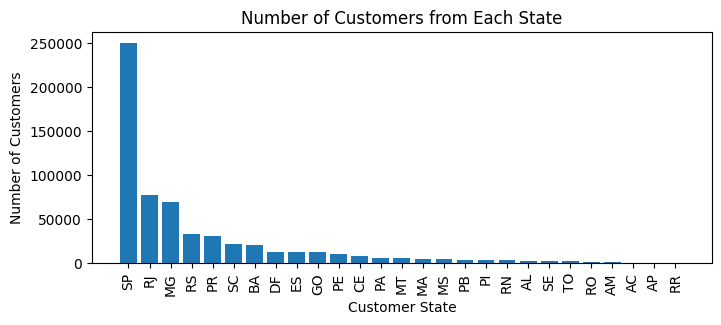

In [8]:
import mysql.connector

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="MYfriNK@2024",
    database="ecommerce"
)

cursor = db.cursor()

query = """
select customer_state, count(customer_id)
from customers group by customer_state;
"""

cursor.execute(query)
data = cursor.fetchall()
data
df=pd.DataFrame(data, columns=['Customer_State', 'Customer_Count'])
df=df.sort_values(by='Customer_Count', ascending=False)
# df
plt.figure(figsize=(8,3))
plt.bar(df['Customer_State'], df['Customer_Count'])
plt.xlabel('Customer State')
plt.ylabel('Number of Customers')
plt.title('Number of Customers from Each State')
plt.xticks(rotation=90)
plt.show()

Intermediate Queries


1. Calculate the number of orders per month in 2018.


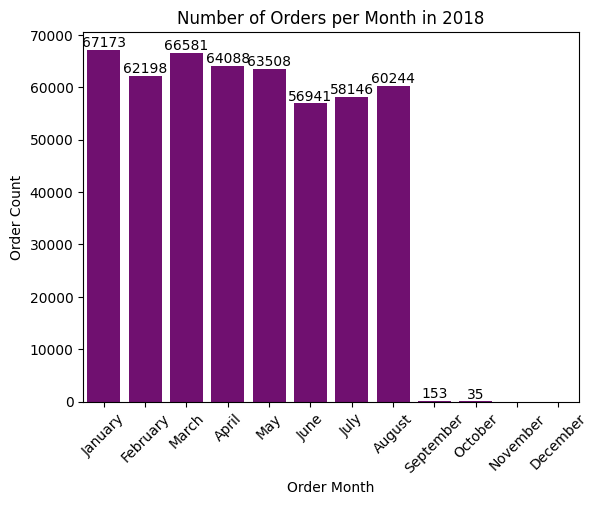

In [30]:
import mysql.connector

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="MYfriNK@2024",
    database="ecommerce"
)

cursor = db.cursor()

query = """
select monthname(order_purchase_timestamp) as order_month, 
count(order_id) as order_count
from orders where year(order_purchase_timestamp)=2018
group by order_month;
"""

cursor.execute(query)
data = cursor.fetchall()
df=pd.DataFrame(data, columns=['Order_Month', 'Order_Count'])
o= ["January","February","March","April","May","June","July",
    "August","September","October","November","December"]
ax=sns.barplot(x=df["Order_Month"], y=df["Order_Count"], 
               data=df, order=o, color='purple')
plt.xlabel('Order Month')   
plt.ylabel('Order Count')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title('Number of Orders per Month in 2018')
plt.show()

2. Find the average number of products per order, grouped by customer city.


In [31]:
import pandas as pd 
import mysql.connector

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="MYfriNK@2024",
    database="ecommerce"
)

cursor = db.cursor()

# Use MONTH() to preserve chronological order, then MONTHNAME() for labels
query = """
 with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from ecommerce.orders join ecommerce.order_items
on orders.order_id=order_items.order_id
group by orders.order_id, orders.customer_id)
 
select customers.customer_city, round(avg(count_per_order.oc),2)
from ecommerce.customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by avg(count_per_order.oc) desc; 
"""

cursor.execute(query)
data = cursor.fetchall()
data
df=pd.DataFrame(data, columns=['Customer_City', 'Avg_product_Per_order'])
df=df.head(10)
df

,Customer_City,Avg_product_Per_order
0,padre carvalho,350.00
1,celso ramos,265.00
2,datas,240.00
3,candido godoi,240.00
4,picarra,200.00
5,teixeira soares,200.00
6,cidelandia,200.00
7,matias olimpio,200.00
8,inconfidentes,170.00
9,curralinho,160.00


3. Calculate the percentage of total revenue contributed by each product category.

In [32]:
import pandas as pd 
import mysql.connector  

db=mysql.connector.connect(
    host="localhost",
    user="root",                                   
    password="MYfriNK@2024",
    database="ecommerce"    
)       
cursor=db.cursor()  
query = """ select upper(products.product_category) category , 
round((sum(payments.payment_value)/(select sum(payment_value) 
from ecommerce.payments))*100,2) sales 
from ecommerce.products join ecommerce.order_items
on products.product_id=order_items.product_id
join ecommerce.payments
on payments.order_id=order_items.order_id
group by category order by sales desc;
"""
cursor.execute(query)
data=cursor.fetchall()
data
df = pd.DataFrame(data, columns=['Category', 'Sales_Percentage_revenue'])
df.head()    

,Category,Sales_Percentage_revenue
0,BED TABLE BATH,251.09
1,HEALTH BEAUTY,241.77
2,COMPUTER ACCESSORIES,233.36
3,FURNITURE DECORATION,210.92
4,WATCHES PRESENT,210.23


4. Identify the correlation between product price and the number of times a product has been purchased.

In [ ]:
import pandas as pd 
import mysql.connector  
import numpy as np

db=mysql.connector.connect(
    host="localhost",
    user="root",                                   
    password="MYfriNK@2024",
    database="ecommerce"    
)       
cursor=db.cursor()  
query = """ select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from ecommerce.products join ecommerce.order_items
on products.product_id= order_items.product_id
group by product_category;
"""
cursor.execute(query)
data=cursor.fetchall()
data
df = pd.DataFrame(data, columns=['product_category', 'order_count', 'avg_price'])
arr1=df["order_count"]
arr2=df["avg_price"]
np.correlation = np.corrcoef(arr1, arr2)[0, 1] 
print("Correlation coefficient between order count and average price:", np.correlation)     

Correlation coefficient between order count and average price: -0.1078901108337839


5. Calculate the total revenue generated by each seller, and rank them by revenue.


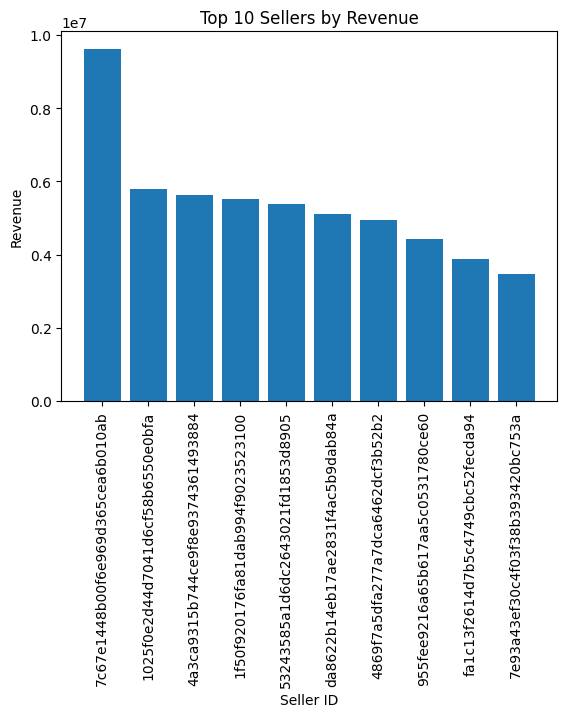

In [35]:
import pandas as pd 
import matplotlib.pyplot as plt
import mysql.connector  

db=mysql.connector.connect(
    host="localhost",
    user="root",                                   
    password="MYfriNK@2024",
    database="ecommerce"    
)       
cursor=db.cursor()  
query = """ select *,dense_rank() over(order by revenue desc) as revenue_rank from
(select order_items.seller_id,
sum(payments.payment_value) as revenue
from ecommerce.order_items join ecommerce.payments
on order_items.order_id=payments.order_id
group by seller_id) as a;
"""
cursor.execute(query)
data=cursor.fetchall()
data
df = pd.DataFrame(data, columns=['sellers_id', 'revenue', 'rank'])
df
plt.bar(df['sellers_id'].head(10), df['revenue'].head(10))
plt.xlabel('Seller ID') 
plt.xticks(rotation=90)    
plt.ylabel('Revenue')
plt.title('Top 10 Sellers by Revenue')
plt.show()

1. Calculate the moving average of order values for each customer over their order history.


In [ ]:
import pandas as pd 
import mysql.connector  

db=mysql.connector.connect(
    host="localhost",
    user="root",                                   
    password="MYfriNK@2024",
    database="ecommerce"    
)       
cursor=db.cursor()  
query = """ select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_avg 
from 
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from ecommerce.orders join ecommerce.payments
on orders.order_id=payments.order_id) as a;
"""
cursor.execute(query)
data=cursor.fetchall()
data
df = pd.DataFrame(data, columns=['customer_id', 'order_purchase_timestamp', 
                                 'payment', 'moving_avg'])
df.head(10)

,customer_id,order_purchase_timestamp,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
5,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
6,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
7,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
8,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
9,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998


2. Calculate the cumulative sales per month for each year.


In [37]:
import pandas as pd 
import mysql.connector  

db=mysql.connector.connect(
    host="localhost",
    user="root",                                   
    password="MYfriNK@2024",
    database="ecommerce"    
)       
cursor=db.cursor()  
query = """ select years,months,payment,sum(payment)
over(order by years,months) as cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment
from ecommerce.orders join ecommerce.payments
on orders.order_id= payments.order_id
group by years,months 
order by years,months asc) as a;
"""
cursor.execute(query)
data=cursor.fetchall()
data
df = pd.DataFrame(data, columns=['Years', 'Months', 'Payments', 'Cumulative_Sales'])
df.head(20)

,Years,Months,Payments,Cumulative_Sales
0,2016,9,10089.60,1.008960e+04
1,2016,10,2185802.76,2.195892e+06
2,2016,12,784.80,2.196677e+06
3,2017,1,5126229.32,7.322906e+06
4,2017,2,10727527.54,1.805043e+07
5,2017,3,16659124.30,3.470956e+07
6,2017,4,15434445.86,5.014400e+07
7,2017,5,21990330.37,7.213433e+07
8,2017,6,18902386.57,9.103672e+07
9,2017,7,21929609.14,1.129663e+08


3. Calculate the year-over-year growth rate of total sales.


In [38]:
import pandas as pd 
import mysql.connector  

db=mysql.connector.connect(
    host="localhost",
    user="root",                                   
    password="MYfriNK@2024",
    database="ecommerce"    
)       
cursor=db.cursor()  
query = """ with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment
from ecommerce.orders join ecommerce.payments
on orders.order_id=payments.order_id
group by years order by years)
select years, payment, lag(payment, 1) over(order by years) as previous_year_payment from a;
"""
cursor.execute(query)
data=cursor.fetchall()
data
df = pd.DataFrame(data, columns=['Year', 'Sales', 'Previous_Year_Sales'])
df

,Year,Sales,Previous_Year_Sales
0,2016,2.196677e+06,NaN
1,2017,2.679593e+08,2.196677e+06
2,2018,3.214953e+08,2.679593e+08


In [ ]:
import pandas as pd 
import mysql.connector  

db=mysql.connector.connect(
    host="localhost",
    user="root",                                   
    password="MYfriNK@2024",
    database="ecommerce"    
)       
cursor=db.cursor()  
query = """ with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment
from ecommerce.orders join ecommerce.payments
on orders.order_id=payments.order_id
group by years order by years)
select years, ((payment-lag(payment, 1) over(order by years))/lag(payment, 1) 
over(order by years)) * 100 as previous_year_payment from a;
"""
cursor.execute(query)
data=cursor.fetchall()
data
df = pd.DataFrame(data, columns=['Year', 'yoy_growth%',])
df

,Year,yoy_growth%
0,2016,NaN
1,2017,12098.393766
2,2018,19.979136


4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [ ]:
import mysql.connector  

db=mysql.connector.connect(
    host="localhost",
    user="root",                                   
    password="MYfriNK@2024",
    database="ecommerce"    
)       
cursor=db.cursor()  
query = """ with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) as first_order
from ecommerce.customers join ecommerce.orders
on customers.customer_id=orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) as next_order
from a join ecommerce.orders
on a.customer_id= orders.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp <
date_add(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b 
on a.customer_id=b.customer_id;
"""
cursor.execute(query)
data=cursor.fetchall()
data

[(None,)]

5. Identify the top 3 customers who spent the most money in each year.

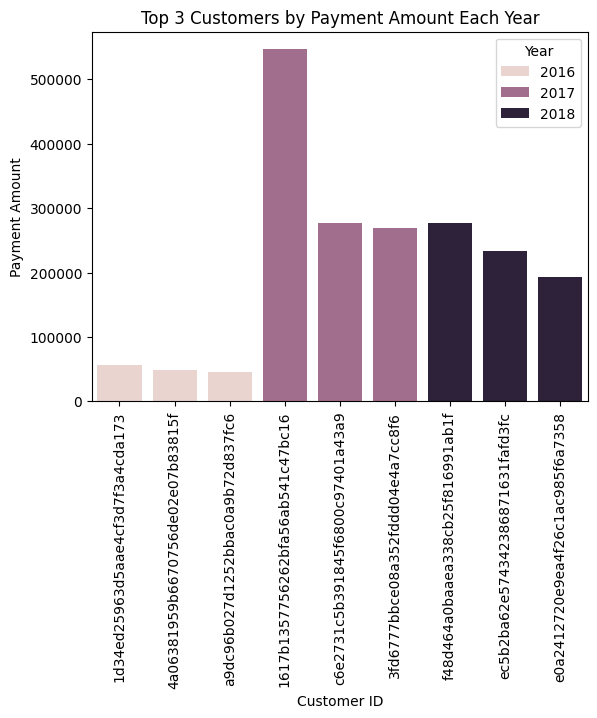

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import mysql.connector 

db=mysql.connector.connect(
    host="localhost",
    user="root",                                   
    password="MYfriNK@2024",
    database="ecommerce"    
)       
cursor=db.cursor()  
query = """ select years,customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp) as years,orders.customer_id,
sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) as d_rank
from ecommerce.orders join ecommerce.payments
on orders.order_id=payments.order_id
group by year(order_purchase_timestamp),orders.customer_id) as a
where d_rank<=3;
"""
cursor.execute(query)
data=cursor.fetchall()
data
df = pd.DataFrame(data, columns=['Year', 'Customer_ID', 'Payment', 'Rank'])
sns.barplot(x='Customer_ID', y='Payment', hue='Year', data=df)
plt.xticks(rotation=90)
plt.xlabel('Customer ID')       
plt.ylabel('Payment Amount')
plt.title('Top 3 Customers by Payment Amount Each Year')
plt.show()